## MS-SMC' validation

This notebook validates the MS-SMC' calculations from McKenzie and Eaton (XXXX) by comparing the analytical predictions to the results of stochastic coalescent simulations.

In [1]:
# conda install ipcoal toytree -c conda-forge

In [2]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import pandas as pd
import ipcoal
import toyplot, toyplot.svg, toyplot.png
import toytree
from scipy import stats

### Parameters
These are global parameters used for analyses in the manuscript. The NLOCI variable is changed further below.

In [13]:
RECOMB = 2e-9
SPECIES_TREE_HEIGHT = 1e6
NEFF_MIN = 50_000
NEFF_MAX = 500_000
NEFF_VALS = 10
SEED = 123
NLOCI = 4
NREPS = 10

### Generate a species tree for model 1 tip, 2 tips, or 8 tips
There are the 3 species tree models used. Below is a function for generating them.

In [4]:
sptree = toytree.tree("(a);")
sptree = sptree.mod.edges_scale_to_root_height(treeheight=SPECIES_TREE_HEIGHT, include_stem=True)
sptree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="255.0px" viewBox="0 0 350.0 255.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t50634c940bd84b1faed8d0c32521c14a"> 0 1 a 0 250000 500000

In [5]:
sptree = toytree.rtree.baltree(2)
sptree = sptree.mod.edges_scale_to_root_height(treeheight=SPECIES_TREE_HEIGHT, include_stem=True)
sptree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc146943925984e52ae85bd24858c230e"> 0 1 2 r0 r1 0 250000 500000

In [6]:
sptree = toytree.rtree.baltree(8)
sptree = sptree.mod.edges_scale_to_root_height(treeheight=SPECIES_TREE_HEIGHT, include_stem=True)
sptree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdd122d1b7b2f4d7a9d3f7239b54b323c"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r1 r2 r3 r4 r5 r6 r7 0 250000 500000 750000

In [7]:
def get_sptree(ntips: int) -> toytree.ToyTree:
    """Return a balanced species tree with the specified number of tips and even branch lengths."""
    if ntips == 1:
        sptree = toytree.tree("(a);")
    else:
        sptree = toytree.rtree.baltree(ntips)
    sptree = sptree.mod.edges_scale_to_root_height(SPECIES_TREE_HEIGHT, include_stem=True)
    return sptree

### Get waiting distances to event x:

This is the main function for validating predictions against simulations.

In [8]:
def get_sim_and_analytical(
    sptree: toytree.ToyTree, nsamples: int, neff: int, nsites: int, seed: int, smc: bool,
    ) -> np.ndarray:
    """Return the prob and waiting distance for tree-change and topo-change for analytical and 
    simulations.
    
    Analytical results are computed for the first genealogy in a locus. Simulated results 
    are found by examining subsequent genealogies in the tree sequence until each event
    type is observed. 
    
    This uses some global variables (see above).
    
    Parameters
    ----------
    sptree: ToyTree
        A species tree with edge lengths in units of generations
    nsamples: int
        Number of haploid sampler per species tree tip.
    neff: int
        A diploid effective population size applied to all sptree edges.
    nsites: int
        Number of linked sites to simulate.
    seed: int
        A seed for the random number generator
    """
    model = ipcoal.Model(
        sptree, 
        Ne=neff, 
        seed_trees=seed, 
        nsamples=nsamples, 
        recomb=RECOMB,
        record_full_arg=True,
        ancestry_model="smc_prime" if smc else "hudson",  # use default (Hudson)
    )
    imap = model.get_imap_dict()
    
    # store results in arrays
    # 0 = smc_tree_probs
    # 1 = smc_topo_probs
    # 2 = smc_tree_dists
    # 3 = smc_topo_dists
    # 4 = sim_tree_dists
    # 5 = sim_topo_dists
    # 6 = sum_edge_lengths of genealogy 0
    # 7 = event type
    results = np.zeros(shape=(NLOCI, 8))
    
    # iterate over number of loci (replicates)
    for lidx in range(NLOCI):
        
        # get FULL tree sequence given the parameterized ipcoal.Model
        ts = next(model._get_tree_sequence_generator(nsites=nsites))
        
        # get SIMPLE tree sequence for fetching simplified trees at breakpoints
        # from the FULL `ts`, since no-change breakpoints disappear in `sts`.
        sts = ts.simplify(filter_sites=False)

        # get the starting tree and its sum branch lengths
        tree0 = sts.at(0, sample_lists=True)
        tsumlen0 = tree0.get_total_branch_length()
        results[lidx, 6] = tsumlen0

        # compute analytical probabilities of change given tree0
        toy0 = toytree.tree(tree0.as_newick(node_labels=model.tipdict))
        results[lidx, 0] = ipcoal.smc.get_probability_of_tree_change(model.tree, toy0, imap)
        results[lidx, 1] = ipcoal.smc.get_probability_of_topology_change(model.tree, toy0, imap)
        
        # compute analytical E[waiting distances] given tree0
        tree_rate = tsumlen0 * results[lidx, 0] * RECOMB
        topo_rate = tsumlen0 * results[lidx, 1] * RECOMB
        results[lidx, 2] = stats.expon.mean(scale=1 / tree_rate)
        results[lidx, 3] = stats.expon.mean(scale=1 / topo_rate)
        
        # get the next simulated tree (simplified tree at end of interval 0 of non-simple ts)
        tree1 = sts.at(ts.at(0).interval[1], sample_lists=True)
        
        # store type of first event: 0=no-change, 1=tree-change, 2=topo-change
        if tree0.kc_distance(tree1, lambda_=1):      # diff in blens only
            if tree0.kc_distance(tree1, lambda_=0):  # diff in topology only
                results[lidx, 7] = 2
                results[lidx, 4] = tree1.interval[0]
                results[lidx, 5] = tree1.interval[0]
            else:
                results[lidx, 7] = 1
                results[lidx, 4] = tree1.interval[0]
        else:
            results[lidx, 7] = 0

        # if waiting distances already found then continue to next locus
        if results[lidx, 5]:
            continue
        
        # iterate over trees from index 2 -> End to get waiting distances until the 
        # first observed tree and topo-change events from simulation.
        for idx in range(2, 999999):
            interval = ts.at_index(idx).interval
            tree1 = sts.at(interval[0], sample_lists=True)
                
            # if no difference in branch lengths then go to next idx
            if tree0.kc_distance(tree1, lambda_=1):     # diff in blens only
                if not results[lidx, 4]:
                    results[lidx, 4] = tree1.interval[0]
                if tree0.kc_distance(tree1, lambda_=0):  # diff in topology only
                    results[lidx, 5] = tree1.interval[0]
                    break
    return results

In [9]:
# example results array
sptree = get_sptree(8)
get_sim_and_analytical(sptree, nsamples=1, neff=100000, nsites=500_000, seed=123, smc=False)

array([[5.54764539e-01, 1.53804181e-01, 1.57655692e+02, 5.68656759e+02,
        1.03000000e+02, 2.37900000e+03, 5.71678234e+06, 1.00000000e+00],
       [5.52203657e-01, 2.80267923e-01, 1.86793057e+02, 3.68032873e+02,
        9.90000000e+01, 9.90000000e+01, 4.84741270e+06, 0.00000000e+00],
       [5.38887852e-01, 2.11229182e-01, 2.04351239e+02, 5.21340846e+02,
        1.11400000e+03, 1.11400000e+03, 4.54040231e+06, 0.00000000e+00],
       [5.46230438e-01, 1.19758179e-01, 2.23907949e+02, 1.02126917e+03,
        4.18000000e+02, 8.74000000e+02, 4.08812904e+06, 0.00000000e+00]])

## ----

## Distribute jobs to run in parallel

Also, to compare results of the Hudson and SMC' ancestry methods

In [43]:
def distribute_jobs(sptree: toytree.ToyTree, nsamples: int, outname: str="validation_full"):
    """Parallelize get_sim_and_analytical() function across Ne values and reps.    
    """
    # compare smc and full
    smc_results = np.zeros((NLOCI * NREPS, NEFF_VALS, 8))
    full_results = np.zeros((NLOCI * NREPS, NEFF_VALS, 8))

    # Ne values to test over
    nes = np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int)

    # run jobs in parallel to fill array
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=50) as pool:

        # apply a different seed to each rep
        rng = np.random.default_rng(SEED)
        for rep in range(NREPS):
            seed = rng.integers(1e9)

            # apply same seed for each diff value of Ne
            for nidx, neff in enumerate(nes):

                # submit smc' jobs
                kwargs = {
                    "sptree": sptree,
                    "nsamples": nsamples,
                    "neff": neff, 
                    "nsites": int(550000 - neff), 
                    "seed": seed, 
                    "smc": True,
                }
                rasyncs[(nidx, 'smc', rep)] = pool.submit(get_sim_and_analytical, **kwargs)
                
                # submit full (non-smc') jobs
                kwargs = {
                    "sptree": sptree, 
                    "nsamples": nsamples,
                    "neff": neff, 
                    "nsites": int(550000 - neff), 
                    "seed": seed, 
                    "smc": False,
                }
                rasyncs[(nidx, 'full', rep)] = pool.submit(get_sim_and_analytical, **kwargs)

    # collect results into large res array
    for key, future in rasyncs.items():
        nidx, name, rep = key
        ival = slice(NLOCI * rep, NLOCI * (rep + 1))
        if name == 'smc':
            iresults = future.result()
            smc_results[ival, nidx, :] = iresults
        else:
            iresults = future.result()
            full_results[ival, nidx, :] = iresults
           
    np.save(f"./{outname}_{sptree.ntips}pops_full.npy", full_results)
    np.save(f"./{outname}_{sptree.ntips}pops_smcprime.npy", smc_results)

### RUN it

In [50]:
# 10K reps for each job, split into 100 parallelizable jobs
NLOCI = 100
NREPS = 100

In [51]:
sptree = get_sptree(1)
distribute_jobs(sptree, nsamples=8, outname="validation-final")

In [52]:
sptree = get_sptree(2)
distribute_jobs(sptree, nsamples=4, outname="validation-final")

In [53]:
sptree = get_sptree(8)
distribute_jobs(sptree, nsamples=1, outname="validation-final")

### Load results

Error caused in analytical estimates is measured as $\frac{simulated - analytical}{simulated}$.

In [349]:
a = np.load("./validation-final_8pops_full.npy")
b = np.load("./validation-final_8pops_smcprime.npy")

In [374]:
((a[:, :, 4] - a[:, :, 2]) / a[:, :, 4]).mean(axis=0)

array([-4.59030092, -4.40229647, -4.1316947 , -3.79402068, -3.92019075,
       -3.45522642, -3.36511008, -3.44559901, -3.25253423, -3.26666605])

In [375]:
((b[:, :, 4] - b[:, :, 2]) / b[:, :, 4]).mean(axis=0)

array([-4.73726394, -4.12287292, -3.64284496, -3.77202092, -3.71892765,
       -3.54784095, -3.45764242, -3.4522992 , -3.4805942 , -3.30574509])

In [371]:
b[:, :, 4].mean(0)

array([295.6935, 183.9866, 148.8412, 123.724 , 108.8961,  98.2899,
        89.7001,  83.4087,  75.207 ,  71.4207])

In [355]:
(a[:, :, 4].mean(axis=0) - a[:, :, 2].mean(axis=0)) / a[:, :, 4].mean(axis=0)

array([ 0.00743978,  0.01959016,  0.00051489,  0.00822606, -0.01154297,
        0.00813825,  0.01890934, -0.00412956,  0.01330297,  0.03519777])

In [356]:
(b[:, :, 4].mean(axis=0) - b[:, :, 2].mean(axis=0)) / b[:, :, 4].mean(axis=0)

array([-0.0122438 , -0.00515667,  0.0253843 ,  0.00986729,  0.01029749,
        0.01370282,  0.01453861,  0.01781736, -0.01048857, -0.00010789])

In [361]:
def load_errors(full_path: str, smc_path: str):
    """Return the errors from the SMC' approximation.
    
    # results in arrays
    # 0 = smc_tree_probs
    # 1 = smc_topo_probs
    # 2 = smc_tree_dists
    # 3 = smc_topo_dists
    # 4 = sim_tree_dists
    # 5 = sim_topo_dists
    # 6 = sum_edge_lengths of genealogy 0
    # 7 = event type
    """
    res0 = np.load(full_path)  
    res1 = np.load(smc_path)  

    newdata = pd.DataFrame(
        data={
            'fullsim_minus_prediction_tree_error_perc': (
                (res0[:, :, 4] - res0[:, :, 2]) #/ res0[:, :, 4]
            ).mean(axis=0),
            'fullsim_minus_prediction_tree_error_perc_sem': stats.sem(
                (res0[:, :, 4] - res0[:, :, 2]) #/ res0[:, :, 4]
            ),
 
            'fullsim_minus_prediction_topo_error_perc': (
                (res0[:, :, 5] - res0[:, :, 3]) / 
                res0[:, :, 5]
            ).mean(axis=0),  
            'fullsim_minus_prediction_topo_error_perc_sem': stats.sem(
                (res0[:, :, 5] - res0[:, :, 3]) / 
                res0[:, :, 5]
            ),
            
            'smcsim_minus_prediction_tree_error_perc': (
                (res1[:, :, 4] - res1[:, :, 2]) / 
                res0[:, :, 4]
            ).mean(axis=0), 
            'smcsim_minus_prediction_tree_error_perc_sem': stats.sem(
                (res1[:, :, 4] - res1[:, :, 2]) / 
                res0[:, :, 4]
            ),
            
            'smcsim_minus_prediction_topo_error_perc': (
                (res1[:, :, 5] - res1[:, :, 3]) / 
                res0[:, :, 5]
            ).mean(axis=0), 
            'smcsim_minus_prediction_topo_error_perc_sem': stats.sem(
                (res1[:, :, 5] - res1[:, :, 3]) / 
                res0[:, :, 5]
            )
        },
        index=np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int),
    )
    return newdata

In [362]:
load_errors("./validation-final_8pops_full.npy", "./validation-final_8pops_smcprime.npy")

,fullsim_minus_prediction_tree_error_perc,fullsim_minus_prediction_tree_error_perc_sem,fullsim_minus_prediction_topo_error_perc,fullsim_minus_prediction_topo_error_perc_sem,smcsim_minus_prediction_tree_error_perc,smcsim_minus_prediction_tree_error_perc_sem,smcsim_minus_prediction_topo_error_perc,smcsim_minus_prediction_topo_error_perc_sem
50000,2.245660,3.082041,-5.817518,0.611133,0.076681,0.235017,-0.667029,0.524612
100000,3.700740,1.885316,-5.344043,0.306003,-0.176316,0.184483,0.075489,0.381169
150000,0.074851,1.464154,-5.020287,0.241017,0.125853,0.164224,0.379740,0.274494
200000,1.016310,1.242894,-4.434418,0.185454,0.061661,0.151745,0.115508,0.177933
250000,-1.228702,1.073229,-4.518322,0.177365,-0.125024,0.132088,0.078071,0.219767
300000,0.794459,0.972232,-3.999984,0.146726,0.134410,0.140733,0.086524,0.172295
350000,1.705759,0.909467,-3.866804,0.140165,-0.152067,0.114256,0.109440,0.179630
400000,-0.335397,0.819513,-4.013815,0.140698,0.000373,0.107967,0.278140,0.165505
450000,1.029320,0.792145,-3.737175,0.128818,-0.168442,0.098568,0.273665,0.155026
500000,2.599700,0.763756,-3.757325,0.132450,-0.079732,0.103310,-0.179083,0.129173


In [126]:
def load_data(path):
    """Return large array results summarized into a dataframe.
    
    # 0 = smc_tree_probs
    # 1 = smc_topo_probs
    # 2 = smc_tree_dists
    # 3 = smc_topo_dists
    # 4 = sim_tree_dists
    # 5 = sim_topo_dists
    # 6 = sum_edge_lengths of genealogy 0
    # 7 = event type
    """
    results = np.load(path)  
    
    newdata = pd.DataFrame(
        data={
            'tree_smc_prob': results[:, :, 0].mean(axis=0),
            'topo_smc_prob': results[:, :, 1].mean(axis=0),
            'tree_smc_dist': results[:, :, 2].mean(axis=0),
            'topo_smc_dist': results[:, :, 3].mean(axis=0),       
            'tree_sim_prob': (results[:, :, 7] != 0).mean(0),
            'topo_sim_prob': (results[:, :, 7] == 2).mean(0),
            'tree_sim_dist': results[:, :, 4].mean(axis=0),
            'topo_sim_dist': results[:, :, 5].mean(axis=0),

            'tree_smc_prob_CI95':  tuple(zip(
                np.percentile(results[:, :, 0], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 0], 97.5, axis=0).round(5),
            )),
            'topo_smc_prob_CI95':  tuple(zip(
                np.percentile(results[:, :, 1], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 1], 97.5, axis=0).round(5),
            )),

            'tree_smc_dist_CI95':  tuple(zip(
                np.percentile(results[:, :, 2], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 2], 97.5, axis=0).round(5),
            )),
            'topo_smc_dist_CI95':  tuple(zip(
                np.percentile(results[:, :, 3], 2.5, axis=0).round(5),
                np.percentile(results[:, :, 3], 97.5, axis=0).round(5),
            )),
            'tmrca': results[:, :, 6].mean(axis=0),
        },
        index=np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int),
    )
    newdata['nsamples'] = NLOCI * NREPS
    return newdata

In [127]:
data = load_data("./validation_full_2pops.npy")
data

,tree_smc_prob,topo_smc_prob,tree_smc_dist,topo_smc_dist,tree_sim_prob,topo_sim_prob,tree_sim_dist,topo_sim_dist,tree_smc_prob_CI95,topo_smc_prob_CI95,tree_smc_dist_CI95,topo_smc_dist_CI95,tmrca,nsamples
50000,0.478757,0.111213,676.268799,3654.401925,0.4774,0.1093,675.3757,3582.1332,"(0.35682, 0.58968)","(0.03462, 0.23607)","(400.46634, 1094.71949)","(1130.48907, 9634.67349)",1.631340e+06,10000
100000,0.646151,0.225855,363.881016,1321.674949,0.6474,0.2282,362.5759,1303.2978,"(0.53602, 0.72513)","(0.07393, 0.45016)","(219.17838, 579.45744)","(411.92082, 3439.35414)",2.258646e+06,10000
150000,0.709904,0.313065,260.326753,701.879038,0.7104,0.3126,265.0879,717.6677,"(0.6106, 0.77856)","(0.11164, 0.51751)","(154.84618, 415.39722)","(285.81673, 1775.83932)",2.897600e+06,10000
200000,0.740947,0.367595,207.779292,471.085088,0.7430,0.3687,210.0198,475.3567,"(0.64008, 0.80942)","(0.14678, 0.56616)","(119.75943, 332.09229)","(216.09206, 1117.71679)",3.512331e+06,10000
250000,0.758430,0.399244,175.429929,365.796188,0.7595,0.4050,175.4391,364.2903,"(0.64994, 0.82855)","(0.16764, 0.59391)","(101.35483, 291.65201)","(179.65041, 839.06861)",4.090813e+06,10000
300000,0.770349,0.421542,152.285179,300.711882,0.7724,0.4228,154.2638,304.1593,"(0.65554, 0.84176)","(0.18132, 0.61643)","(86.30296, 252.68551)","(152.85254, 656.09956)",4.672879e+06,10000
350000,0.778406,0.434678,134.704801,257.274349,0.7810,0.4326,135.8442,259.2106,"(0.66137, 0.85099)","(0.19871, 0.63489)","(75.19905, 227.33365)","(133.13225, 514.27454)",5.245334e+06,10000
400000,0.783426,0.442923,120.886196,227.550116,0.7860,0.4406,121.9483,228.4511,"(0.65704, 0.85879)","(0.19749, 0.64864)","(66.14219, 206.37715)","(118.10011, 444.08066)",5.849824e+06,10000
450000,0.789172,0.450712,110.766089,204.429160,0.7896,0.4551,112.1042,209.1004,"(0.66305, 0.86532)","(0.20441, 0.65532)","(60.65237, 189.04474)","(109.50605, 387.53868)",6.347644e+06,10000
500000,0.791365,0.452936,101.172475,186.493868,0.7933,0.4496,101.1601,185.2469,"(0.6602, 0.86852)","(0.20559, 0.66422)","(54.35087, 175.71241)","(99.2669, 354.14556)",6.969181e+06,10000


# Plot results

### Plot probabilities

In [338]:
def plot_probs(data, topo: bool=False, smc: bool=False):
    """Plot probabilities of tree or topology change.
    
    """      
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    color = toytree.color.COLORS2[0]
    canvas = toyplot.Canvas(width=350, height=300)
    
    # setup axes
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")
    axb.x.label.text = "N<sub>e</sub> (diploid)"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "P(topo-change | S,G)" if topo else "P(tree-change | S,G)"
    axb.y.domain.max = 1
    axb.y.domain.min = 0
    axb.x.domain.min = 0
    
    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
        
    avgdist = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50_000, 500_000, 4),
        #np.linspace(0.5, 5, 5),
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50_000, 500_000, 4),
        (avgdist / (2 * np.linspace(50_000, 500_000, 4))).round(1),
    )
        
    # plot data
    cmap = toyplot.color.brewer.palette("BlueRed", NEFF_VALS)
    axb.hlines([0, 0.5, 1.0], style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7})
    axb.fill(
       data.index,
       [i[0] for i in data[smckey + "prob_CI95"]],
       [i[1] for i in data[smckey + "prob_CI95"]],
       opacity=0.25,
       color="grey",
    )
    axb.plot(data.index, data[simkey + "prob"], stroke_width=2, color='black')
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.scatterplot(data.index, data[smckey + "prob"], size=16,
                        color=[cmap[i] for i in range(NEFF_VALS)], 
                        mstyle={"stroke-width": 1.5, "fill-opacity": 0.5, "stroke": "black"}),
        axb.scatterplot(data.index, data[simkey + "prob"], size=6, marker='s', **style),
    ]
    return canvas

In [343]:
for nspecies in [1, 2, 8]:
    for smc in [True, False]:
        for topo in [True, False]:
            data = load_data(f"./validation_full_{nspecies}pops.npy")
            canvas = plot_probs(data, topo=topo, smc=smc)
            ttt = 'topo' if topo else 'tree'
            #toyplot.svg.render(canvas, 
            #    f"../manuscript/figures/alternatives/validation-colorprobs-{nspecies}pops-{ttt}-smc{int(smc)}-final.svg")


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t4f019b5b0ccc4ec09a012ed011cadce5"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tda52c3ac30b04dbe91feddfb6dc6b90f"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t6ea3594bc0bd4a5dbf5086ebafe028f9"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tcc71d5b554e04f369b145da09131badc"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="ta5b96f1d487f448eb64f15e8ef03e2a9"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc3eba9fa5758483fa339d229d4f71177"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdf4b088790d54373ae836cea79bf219f"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9eb5bd30171747e3be20b3e6a6343947"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t99757cf5cd09466386eac3e5657d594d"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0bafe7c296804a8dbf4a426c4d12a323"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t5c8a3b8964ca4b128bb4e77f7c2dbf2a"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t15269dad7a5243c59d5e28ba52fdfd94"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

## Plot distances

In [332]:
def plot_distances(data, topo: bool=False, log: bool=True, smc: bool=False):
    """Plot waiting distances until tree or topology change.
    
    """
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    color = toytree.color.COLORS2[0]
    canvas = toyplot.Canvas(width=350, height=300)
    
    # setup axes
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")#, yscale="log")
    axb.x.label.text = "N<sub>e</sub> (diploid)"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "Distance to topo-change" if topo else "Distance to tree-change"
    axb.x.domain.min = 0
        
    if log:
        axt.y.scale = "log"
        axb.y.domain.min = 50
        axb.y.domain.max = 1e4
    else:
        axb.y.domain.min = 10
        axb.y.domain.max = 10000
    
    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3

    avgdist = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
        (avgdist / (2 * np.linspace(NEFF_MIN, NEFF_MAX, 4))).round(1),
    )
    axt.y.ticks.locator = toyplot.locator.Explicit([100, 1000, 10000])

    axb.hlines([100, 1000, 10000], style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7})

    # plot data
    cmap = toyplot.color.brewer.palette("BlueRed", NEFF_VALS)
    axb.fill(
       data.index,
       [i[0] for i in data[smckey + "dist_CI95"]],
       [i[1] for i in data[smckey + "dist_CI95"]],
       opacity=0.25, color="grey",
    )
    axb.plot(data.index, data[simkey + "dist"], stroke_width=3, color='black')#color)
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.scatterplot(data.index, data[smckey + "dist"], 
                        size=16, marker="o", 
                        color=[cmap[i] for i in range(NEFF_VALS)], 
                        #opacity=0.5, 
                        mstyle={"stroke": "black", "stroke-width": 1.5, "fill-opacity": 0.5},
                       ),
        axb.scatterplot(data.index, data[simkey + "dist"], size=7, marker='s', **style),
    ]
    return canvas

In [333]:
for nspecies in [1, 2, 8]:
    for smc in [True, False]:
        for topo in [True, False]:
            data = load_data(f"./validation_full_{nspecies}pops.npy")
            canvas = plot_distances(data, topo=topo, log=True, smc=smc)
            ttt = 'topo' if topo else 'tree'
            #toyplot.svg.render(canvas, 
            #   f"../manuscript/figures/alternatives/validation-colordists-{nspecies}pops-{ttt}-smc{int(smc)}-final.svg")


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf87872daedc3490a96923415e8c6125d"> <polygon points="87.0,130.9312400111314 109.0,153.1211890276889 131.0,165.90656930834396 153.0,175.01155916025917 175.0,182.11778798530318 197.0,188.5434000261394 219.0,192.98242127727983 241.0,196.9346741929826 263.0,200.90619559064405 285.0,204.21472979109384 285.0,150.86776748619724 263.0,147.98732819799466 241.0,144.06714426077997 219.0,140.22340087140742 197.0,134.98843089719196 175.0,128.65953792973346 153.0,121.02457705626742 131.0,113.10783550852958 109.0,99.96387508172043 87.0,77.4497199329749" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tbe282eec12374c2f93a279e1bbc4da34"> <polygon points="87.0,152.66254941923904 109.0,174.8902772615859 131.0,187.59941426596254 153.0,196.4760425545723 175.0,204.4658370253567 197.0,209.64942689970553 219.0,215.1222856218903 241.0,218.95731240042852 263.0,222.97752114111876 285.0,226.23510769297377 285.0,176.75398425401104 263.0,173.22901483655752 241.0,170.07597152638445 219.0,165.52805562879533 197.0,160.83017259732873 175.0,154.3044294955837 153.0,147.3100809107918 131.0,138.09532902420082 109.0,124.5553027573649 87.0,102.6179329047641" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tcdf3806062b54f69af87de9de4391f10"> <polygon points="87.0,130.9312400111314 109.0,153.1211890276889 131.0,165.90656930834396 153.0,175.01155916025917 175.0,182.11778798530318 197.0,188.5434000261394 219.0,192.98242127727983 241.0,196.9346741929826 263.0,200.90619559064405 285.0,204.21472979109384 285.0,150.86776748619724 263.0,147.98732819799466 241.0,144.06714426077997 219.0,140.22340087140742 197.0,134.98843089719196 175.0,128.65953792973346 153.0,121.02457705626742 131.0,113.10783550852958 109.0,99.96387508172043 87.0,77.4497199329749" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t21ce41f0362046b59710b490c3d6a077"> <polygon points="87.0,152.66254941923904 109.0,174.8902772615859 131.0,187.59941426596254 153.0,196.4760425545723 175.0,204.4658370253567 197.0,209.64942689970553 219.0,215.1222856218903 241.0,218.95731240042852 263.0,222.97752114111876 285.0,226.23510769297377 285.0,176.75398425401104 263.0,173.22901483655752 241.0,170.07597152638445 219.0,165.52805562879533 197.0,160.83017259732873 175.0,154.3044294955837 153.0,147.3100809107918 131.0,138.09532902420082 109.0,124.5553027573649 87.0,102.6179329047641" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf77bdc93b208480bb084698ecc2440b0"> <polygon points="87.0,134.94464121772705 109.0,167.3375028021182 131.0,179.06418023276655 153.0,188.0368152069686 175.0,193.9627707597719 197.0,199.14586006828887 219.0,203.57787355452803 241.0,207.42206718596535 263.0,209.84623029060748 285.0,212.99600288597787 285.0,172.18638793917208 263.0,169.29522474182193 241.0,164.92546132414395 219.0,160.21685778345062 197.0,152.40222573059424 175.0,144.50979766852822 153.0,135.30920873939039 131.0,120.45402568527516 109.0,99.24506755968991 87.0,66.19412166091561" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc0d7ca36d7784600be04cebc311b3fbe"> <polygon points="87.0,168.2423641935958 109.0,187.58179571059867 131.0,198.73007577949568 153.0,206.97439762414044 175.0,212.32812880117845 197.0,217.48633574481687 219.0,221.90534259842687 241.0,226.022952204166 263.0,228.80311375742923 285.0,232.3228491931102 285.0,194.67392278462518 263.0,192.32733553664428 241.0,189.5127298303556 219.0,186.40961538736371 197.0,183.01729789513573 175.0,178.41571163332347 153.0,174.2493386323196 131.0,167.06785259931573 109.0,156.38791672331445 87.0,135.97626531480125" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t382bd11c55ec4f069059a0680b96bd7e"> <polygon points="87.0,134.94464121772705 109.0,167.3375028021182 131.0,179.06418023276655 153.0,188.0368152069686 175.0,193.9627707597719 197.0,199.14586006828887 219.0,203.57787355452803 241.0,207.42206718596535 263.0,209.84623029060748 285.0,212.99600288597787 285.0,172.18638793917208 263.0,169.29522474182193 241.0,164.92546132414395 219.0,160.21685778345062 197.0,152.40222573059424 175.0,144.50979766852822 153.0,135.30920873939039 131.0,120.45402568527516 109.0,99.24506755968991 87.0,66.19412166091561" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t47ced50cf57647dca3745991c37841bd"> <polygon points="87.0,168.2423641935958 109.0,187.58179571059867 131.0,198.73007577949568 153.0,206.97439762414044 175.0,212.32812880117845 197.0,217.48633574481687 219.0,221.90534259842687 241.0,226.022952204166 263.0,228.80311375742923 285.0,232.3228491931102 285.0,194.67392278462518 263.0,192.32733553664428 241.0,189.5127298303556 219.0,186.40961538736371 197.0,183.01729789513573 175.0,178.41571163332347 153.0,174.2493386323196 131.0,167.06785259931573 109.0,156.38791672331445 87.0,135.97626531480125" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2df8f6bd0a4e4f7b81f9e7fd17defe7b"> <polygon points="87.0,156.3477982963669 109.0,182.60787808989554 131.0,193.73645876643482 153.0,200.8421867937689 175.0,206.39578158544677 197.0,210.32646444776938 219.0,213.644428496024 241.0,216.3005311865045 263.0,219.19998034608915 285.0,221.7441912277899 285.0,196.53428460220786 263.0,194.2505668013531 241.0,191.45797145470607 219.0,188.13068425634066 197.0,183.80065180630538 175.0,178.27860692147394 153.0,170.40097674240926 131.0,156.19772809331627 109.0,133.0867957970476 87.0,75.80938202018669" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t1a1c2854b3c54fa1ad00999f4e535b5a"> <polygon points="87.0,185.23076998240208 109.0,201.1592170891338 131.0,210.1809007436805 153.0,216.94499990168035 175.0,221.78957253535242 197.0,225.62060540472453 219.0,229.35007365684942 241.0,232.3769879755382 263.0,235.00429801005026 285.0,235.07942741708544 285.0,212.3139180620835 263.0,210.53967929810344 241.0,208.7300779811655 219.0,206.67676488491145 197.0,204.60256680809263 175.0,201.81493919710138 153.0,198.3905745975864 131.0,193.9684168192156 109.0,187.1932350256918 87.0,172.08138398648202" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2ab20d61fcb0436991c31383d00f46c2"> <polygon points="87.0,156.3477982963669 109.0,182.60787808989554 131.0,193.73645876643482 153.0,200.8421867937689 175.0,206.39578158544677 197.0,210.32646444776938 219.0,213.644428496024 241.0,216.3005311865045 263.0,219.19998034608915 285.0,221.7441912277899 285.0,196.53428460220786 263.0,194.2505668013531 241.0,191.45797145470607 219.0,188.13068425634066 197.0,183.80065180630538 175.0,178.27860692147394 153.0,170.40097674240926 131.0,156.19772809331627 109.0,133.0867957970476 87.0,75.80938202018669" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf5906b4616f54067a4ad722738556923"> <polygon points="87.0,185.23076998240208 109.0,201.1592170891338 131.0,210.1809007436805 153.0,216.94499990168035 175.0,221.78957253535242 197.0,225.62060540472453 219.0,229.35007365684942 241.0,232.3769879755382 263.0,235.00429801005026 285.0,235.07942741708544 285.0,212.3139180620835 263.0,210.53967929810344 241.0,208.7300779811655 219.0,206.67676488491145 197.0,204.60256680809263 175.0,201.81493919710138 153.0,198.3905745975864 131.0,193.9684168192156 109.0,187.1932350256918 87.0,172.08138398648202" style="fill:rgb(50.2%,50.2%,50.2%);fill-opacity:1.0;opacity:0.25;stroke:none"> 50000 200000 350000 500000 N e (diploid) 100 1000 10000 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

## Plot error

In [347]:
def plot_error(fullpath, smcpath, topo:bool=False):
    """Plot the percent error for waiting distances between the analytical expectation
    and result of stochastic simulation, when data were simulated under either the
    full coalescent with recombination, or the SMC'.    
    """
    
    fdata = load_errors(fullpath, smcpath)
    key = 'topo' if topo else 'tree'
    color = toytree.color.COLORS2[0]
    canvas = toyplot.Canvas(width=350, height=300)

    # setup axes
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")#, yscale="log")
    axb.x.label.text = "N<sub>e</sub> (diploid)"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "Mean percent error"
    axb.x.domain.min = 0
    axb.y.domain.min = -10
    axb.y.domain.max = 10

    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3

    sptree = get_sptree(nspecies)
    avgdist = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
        (avgdist / (2 * np.linspace(NEFF_MIN, NEFF_MAX, 4))).round(1),
    )

    axb.hlines([0], style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7})

    # plot data
    axb.fill(
       fdata.index,
       fdata[f"fullsim_minus_prediction_{key}_error_perc"] - 2*fdata[f"fullsim_minus_prediction_{key}_error_perc_sem"], 
       fdata[f"fullsim_minus_prediction_{key}_error_perc"] + 2*fdata[f"fullsim_minus_prediction_{key}_error_perc_sem"], 
       opacity=0.33,
    )
    axb.fill(
       data.index,
       fdata[f"smcsim_minus_prediction_{key}_error_perc"] - 2*fdata[f"smcsim_minus_prediction_{key}_error_perc_sem"], 
       fdata[f"smcsim_minus_prediction_{key}_error_perc"] + 2*fdata[f"smcsim_minus_prediction_{key}_error_perc_sem"], 
       opacity=0.33, color='black',
    )
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.plot(fdata.index, fdata[f"fullsim_minus_prediction_{key}_error_perc"], 
                 size=6, marker="o", color=color, opacity=0.7),
        axb.plot(fdata.index, fdata[f"smcsim_minus_prediction_{key}_error_perc"], 
                 size=6, marker='s', **style),
    ]
    return canvas

In [348]:
nspecies = 8
for nspecies in [1, 2, 8]:
    for topo in [True, False]:
        canvas = plot_error(f"./validation_full_{nspecies}pops.npy", f"./validation_smc_{nspecies}pops.npy", topo)
        #toyplot.svg.render(canvas, f"../manuscript/figures/alternatives/error-{nspecies}-{topo}-final.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t9742b262f9c549cc955422aa84642f1a"> <polygon points="87.0,230.79907424527968 109.0,207.69317161950218 131.0,207.5045061010844 153.0,196.08653346213458 175.0,196.89720051743043 197.0,199.52081398746822 219.0,193.67813006557438 241.0,193.03710756881418 263.0,189.95512626365425 285.0,196.85429040666241 285.0,189.03230809372212 263.0,183.81390863357214 241.0,185.7755587587657 219.0,185.94723233055961 197.0,189.96282051036292 175.0,187.63611391068667 153.0,186.61290555035944 131.0,193.709491963588 109.0,193.51629542270922 87.0,204.0913562990922" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> <polygon points="87.0,162.86402464170237 109.0,166.54952392923673 131.0,165.10397317094964 153.0,158.4874921739879 175.0,155.48477724155947 197.0,158.68304603767126 219.0,158.05539804757925 241.0,157.34293017226526 263.0,156.79666819533315 285.0,158.27311055999195 285.0,150.66450005843194 263.0,151.489961070244 241.0,148.15682728964413 219.0,149.64202874299943 197.0,148.92885168292466 175.0,145.31353124118547 153.0,148.1267968375256 131.0,138.8098809470786 109.0,155.36860516758654 87.0,134.2533663607821" style="fill:rgb(0%,0%,0%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) -10 -5 0 5 10 Mean percent error 5.0 1.2 0.7 0.5 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0e5a327c88824ded83eba0f92db52b6b"> <polygon points="87.0,219.2930318225839 109.0,200.53765435935424 131.0,195.18061767397 153.0,190.681233889748 175.0,193.42006495927964 197.0,195.43745517218676 219.0,188.89072122491498 241.0,188.36667757672507 263.0,184.82678537384697 285.0,188.16240843976482 285.0,182.93431315893508 263.0,180.31932851905427 241.0,182.89674300206866 219.0,182.85489843436454 197.0,188.23127844745957 175.0,185.9831728316072 153.0,184.08321206540217 131.0,186.65092798888347 109.0,190.03481624582963 87.0,199.42520325334428" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> <polygon points="87.0,165.43237728439803 109.0,159.538034036616 131.0,158.31902002942087 153.0,155.6301785134127 175.0,154.80300898432895 197.0,155.21178847932933 219.0,155.51982252861438 241.0,153.65051733771173 263.0,155.08630661412016 285.0,154.60495602040416 285.0,149.03745578683672 263.0,150.25758549152954 241.0,148.1033067642947 219.0,148.38178935991704 197.0,146.29768829431455 175.0,146.7677971394229 153.0,147.9199365001947 131.0,150.68389615385948 109.0,149.49631639955834 87.0,144.31517447771114" style="fill:rgb(0%,0%,0%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) -10 -5 0 5 10 Mean percent error 5.0 1.2 0.7 0.5 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t02c7d4feea2a45e688d7facdfcd66e36"> <polygon points="87.0,220.91043862816645 109.0,219.5471559969621 131.0,194.14469919222725 153.0,199.24142540326812 175.0,198.85435757101138 197.0,197.00977130605696 219.0,193.32708750906468 241.0,189.2060748673033 263.0,189.39351705354602 285.0,185.6945381794505 285.0,180.50322212300742 263.0,183.56184401913137 241.0,183.23862265916597 219.0,186.00531700645018 197.0,188.26935908574558 175.0,187.62970602312637 153.0,189.78828528564281 131.0,185.8278727430282 109.0,201.038328778793 87.0,199.97832390779286" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> <polygon points="87.0,174.11287151317455 109.0,168.94071484438703 131.0,157.10227529305305 153.0,151.78835373321675 175.0,154.80568544303654 197.0,152.99349028685884 219.0,153.31083786578776 241.0,153.9000047177219 263.0,154.40007652424518 285.0,156.62245554743308 285.0,150.7871640231351 263.0,147.80268190802056 241.0,144.78027788032423 219.0,145.6533642986887 197.0,145.76919485746498 175.0,146.12067898153356 153.0,139.44687412934155 131.0,145.8555879190136 109.0,150.30281604576027 87.0,153.97751763618328" style="fill:rgb(0%,0%,0%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) -10 -5 0 5 10 Mean percent error 5.0 1.2 0.7 0.5 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdd839b1d312942d6969791ade5ac26da"> <polygon points="87.0,202.39572263176527 109.0,199.00214498277552 131.0,189.1474751996709 153.0,189.39187007183355 175.0,189.25351175959963 197.0,186.8210253754462 219.0,186.1731655586962 241.0,184.25596864372108 263.0,184.1622100055145 285.0,181.51318705130282 285.0,177.58877385978425 263.0,179.8856909132406 241.0,179.8550084990853 219.0,181.15850996236028 197.0,181.58109651319015 175.0,183.46733513035673 153.0,183.33697397435168 131.0,183.00488353019384 109.0,190.29288201706473 87.0,192.10268273476257" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> <polygon points="87.0,153.7364340794063 109.0,156.13482980194163 131.0,150.73318324025382 153.0,152.21685123993552 175.0,150.31018635977279 197.0,152.21822486759527 219.0,151.22104709251772 241.0,152.60610430370724 263.0,152.0280854819764 285.0,154.39455264783658 285.0,149.87778228145325 263.0,146.999565810147 241.0,147.66480343700977 219.0,145.92615793064138 197.0,146.67479302795283 175.0,142.27379081486922 153.0,145.37845699601195 131.0,141.5708314128982 109.0,148.3601801061662 87.0,140.0620144234779" style="fill:rgb(0%,0%,0%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) -10 -5 0 5 10 Mean percent error 5.0 1.2 0.7 0.5 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tda43c08c95af4df99d5fa9670529b29c"> <polygon points="87.0,209.8381686361483 109.0,200.6264081195135 131.0,196.76972185970814 153.0,190.84527357262488 175.0,191.4209364216027 197.0,186.49421138846418 219.0,185.25064627717876 241.0,186.5092961191965 263.0,183.9559004834032 285.0,184.1889105784206 285.0,179.68561093832872 263.0,179.57608199797227 241.0,181.72555896891217 219.0,180.48502265672067 197.0,181.50552072849953 175.0,185.3905390525575 153.0,184.53983292237427 131.0,188.57514899187728 109.0,190.22231970221748 87.0,189.05963247191875" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> <polygon points="87.0,164.5881524599526 109.0,155.83821411390846 131.0,151.43861140424153 153.0,152.04303893815276 175.0,153.0724427098526 197.0,152.19355207881117 219.0,152.12347062197003 241.0,150.4493935243262 263.0,150.30928374866727 285.0,153.71815402356077 285.0,149.32626213853416 263.0,145.03841585180285 241.0,144.822233723565 219.0,146.0160493222432 197.0,146.33553364462628 175.0,145.60035451338507 153.0,145.99332280373733 131.0,142.10580407970608 109.0,142.87846691953783 87.0,146.75133728547414" style="fill:rgb(0%,0%,0%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) -10 -5 0 5 10 Mean percent error 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t8cb91598d7ac42fabe1c67e9cd21606b"> <polygon points="87.0,192.58999286298385 109.0,190.39817416117836 131.0,187.63472147728297 153.0,184.50418092706013 175.0,185.52990399645591 197.0,181.26708630286075 219.0,180.39434390478908 241.0,181.09480582973708 263.0,179.28796848421348 285.0,179.4479062902768 285.0,176.08541661572008 263.0,176.00511348363975 241.0,177.4803773461034 219.0,176.8125275124103 197.0,177.47176287313334 175.0,181.1133387914112 153.0,179.99417061040154 131.0,182.60408837785732 109.0,184.44086580579318 87.0,185.44512274837467" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> <polygon points="87.0,153.34349859832693 109.0,154.63490056033697 131.0,151.72205465315238 153.0,152.055547305497 175.0,153.30819292431732 197.0,151.24996795036336 219.0,153.23491775959985 241.0,151.8322733839159 263.0,153.10740610223309 285.0,152.4339898460038 285.0,148.92145574518875 263.0,149.7561015042882 241.0,148.16137964052945 219.0,149.3502205349169 197.0,146.46506071985291 175.0,148.81721787857492 153.0,146.89622160409206 131.0,146.13844452823957 109.0,148.36247552684486 87.0,145.35292036437215" style="fill:rgb(0%,0%,0%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) -10 -5 0 5 10 Mean percent error 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

## Plot genealogy lengths

In [165]:
data = np.load("./validation-final_8pops_full.npy")
data[:, 2, 6]

array([5669222.07894874, 5894744.26263116, 5693098.48798255, ...,
       5947432.69402314, 5412054.39962098, 7632191.31217912])

In [182]:
cmap = toyplot.color.brewer.palette("BlueRed", 10)
cmap

In [262]:
def plot_distribution_of_genealogy_lens(ntips: int):
    
    data = np.load(f"./validation-final_{ntips}pops_full.npy")

    canvas = toyplot.Canvas(width=350, height=300)
    axes = canvas.cartesian(
        xlabel="Genealogy sum length (x10<sup>6</sup>)",
        ylabel="Frequency",
        margin=65)
    
    cmap = toyplot.color.brewer.palette("BlueRed", 10)
    max_height = 24e6
    nes = np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int)
    nes = nes[[0, -1]]

    # ...
    axes.x.domain.min = 0
    axes.x.domain.max = max_height
    for ax in (axes.x, axes.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 7.5
        ax.ticks.far = 0
        ax.ticks.labels.offset = 12
        ax.ticks.labels.style["font-size"] = 16
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.ticks.style["stroke-width"] = 3
        ax.spine.style["stroke-width"] = 3
    axes.y.ticks.locator = toyplot.locator.Explicit(np.linspace(0.25, NEFF_VALS * 0.25, NEFF_VALS), [""] * NEFF_VALS)
    axes.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(0, max_height, 4),
        [int(i / 1e6) for i in np.linspace(0, max_height, 4)],
    )
    axes.vlines(
        np.linspace(0, max_height, 4), 
        style={"stroke": "grey", "stroke-width": 2, "stroke-dasharray": "6,6", "stroke-opacity": 0.7},
    )
    
    offset = NEFF_VALS * 0.25
    for nidx in range(NEFF_VALS):
        sumlens = data[:, nidx, 6]
        mag, pos = np.histogram(sumlens, bins=40)
        axes.fill(
            pos[:-1],
            np.repeat(offset, mag.size),
            offset + (mag/mag.max()), 
            style={'stroke': "none", "fill-opacity": 0.33, "fill": cmap[nidx]},
        )
        axes.plot(
            pos[:-1], 
            offset + (mag/mag.max()), 
            #color='black',
            color='black',#cmap[nidx],
            stroke_width=2, 
            style={"stroke-opacity": 0.7}
        )
        offset -= 0.25
        
    return canvas

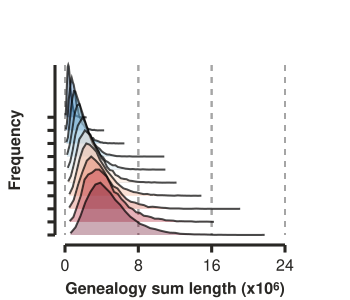

In [263]:
c = plot_distribution_of_genealogy_lens(1)
toyplot.svg.render(c, "../manuscript/figures/alternatives/genealogy-sumlens-1pops-color.svg")
c

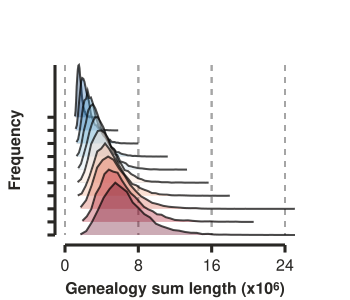

In [264]:
c = plot_distribution_of_genealogy_lens(2)
toyplot.svg.render(c, "../manuscript/figures/alternatives/genealogy-sumlens-2pops-color.svg")
c

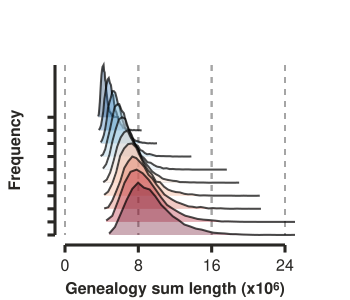

In [265]:
c = plot_distribution_of_genealogy_lens(8)
toyplot.svg.render(c, "../manuscript/figures/alternatives/genealogy-sumlens-8pops-color.svg")
c